In [60]:
##Ridge regression 

import os
import matplotlib.pyplot as plt
import numpy as np
import scripts.implementations as lib  # Add personal library
import scripts.proj1_helpers as helper  # Add personal library

%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

DATA_FOLDER = 'data'
DATA_TRAIN = os.path.join(DATA_FOLDER, 'train.csv')
DATA_TEST = os.path.join(DATA_FOLDER, 'test.csv')

y, x, ids, header = helper.load_csv_data(DATA_TRAIN)
y_train, x_train,  y_validation, x_validation = lib.sep_valid_train_data(x,y,0.2);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
x_train[x_train == -999] = np.nan
x_validation[x_validation == -999] = np.nan

In [64]:
for i, feature in enumerate(x_train.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Feature 1 - DER_mass_MMC has range: [9.2220, 1192.0260]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0000, 690.0750]
Feature 3 - DER_mass_vis has range: [6.3290, 1349.3510]
Feature 4 - DER_pt_h has range: [0.0000, 1053.8070]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0000, 8.5030]
Feature 6 - DER_mass_jet_jet has range: [14.9920, 4974.9790]
Feature 7 - DER_prodeta_jet_jet has range: [-18.0660, 16.6900]
Feature 8 - DER_deltar_tau_lep has range: [0.2080, 5.6550]
Feature 9 - DER_pt_tot has range: [0.0000, 513.6590]
Feature 10 - DER_sum_pt has range: [46.1040, 1852.4620]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.0470, 19.7730]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0000, 764.4080]
Feature 15 - PRI_tau_eta has range: [-2.4990, 2.4970]
Feature 16 - PRI_tau_phi has range: [-3.1420, 3.1420]
Feature 17 - PRI_lep_pt has range: [26.0000, 560.2710]
Fea

In [65]:
# Remove features with NaN
keep_id = np.nonzero(np.sum(np.isnan(x_train), axis=0) == 0)[0]
x_naive = x_train[:, keep_id]
# normalize features
x_naive = (x_naive - np.mean(x_naive, axis=0))/np.std(x_naive, axis=0)

keep_id_val = np.nonzero(np.sum(np.isnan(x_validation), axis=0) == 0)[0]
x_naive_val = x_validation[:, keep_id]
# normalize features
x_naive_val = (x_naive_val - np.mean(x_naive_val, axis=0))/np.std(x_naive_val, axis=0)

np.sum(np.isnan(x_naive_val))

0

In [66]:
from scripts.ml import cross_validation_ls

degrees = np.linspace(1, 6, 6).astype(int)
for i, degree in enumerate(degrees):
    acc, _, _ = cross_validation_ls(y_train, x_naive, degree=degree)
    print('{}/{} Least square deg {} with acc {:.4f}'.format(i+1, len(degrees), degree, acc))

1/6 Least square deg 1 with acc 0.7333
2/6 Least square deg 2 with acc 0.7540
3/6 Least square deg 3 with acc 0.7604
4/6 Least square deg 4 with acc 0.7573
5/6 Least square deg 5 with acc 0.6331
6/6 Least square deg 6 with acc 0.5354


In [85]:
 def plot_train_test(train_errors, test_errors, lambdas, degree):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression for polynomial degree " + str(degree))
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    plt.savefig("ridge_regression")
    
def test_ridge_regression(x, y, x_val, y_val, degrees, lambdas):
    
    best_acc = 0
    best_degree = 0
    best_lambda = 0
    best_rmse_tr = []
    best_rmse_te = []
    best_weights = []
    for degree in degrees:
        degree = int(degree)
        #lambdas = np.logspace(-7, 2, 20)

        # Split sets
        #x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)

        # Get ploynomial
        phi_train = lib.build_poly(x, degree)
        phi_test = lib.build_poly(x_val, degree)

        rmse_tr = []
        rmse_te = []
        update_rmse = False

        for ind, lambda_ in enumerate(lambdas):

            mse_tr, weights = lib.ridge_regression(y, phi_train, lambda_)
            mse_te = lib.compute_loss(y_val, phi_test.dot(weights))
            rmse_tr.append(np.sqrt(2*mse_tr))
            rmse_te.append(np.sqrt(2*mse_te))

            print("degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                    d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
            print('train acc : ', lib.accuracy(y, phi_train.dot(weights)))
            val_acc = lib.accuracy(y_val, phi_test.dot(weights))
            print('validation acc : ', val_acc)

            if(val_acc > best_acc):
                best_acc = val_acc
                best_degree = degree
                best_lambda = lambda_
                best_weights = weights
                update_rmse = True
        
        if(update_rmse):
            best_rmse_tr = rmse_tr
            best_rmse_te = rmse_te

        # Plot the best obtained results
    plot_train_test(best_rmse_tr, best_rmse_te, lambdas, best_degree)

    print('Best params for Ridge regression : degree = ',best_degree, ', lambda = ',best_lambda,', accuracy = ', best_acc)
    
    return best_weights, best_degree, best_lambda

degree=1, lambda=0.000, Training RMSE=0.840, Testing RMSE=0.838
train acc :  0.7332
validation acc :  0.73404
degree=1, lambda=0.000, Training RMSE=0.840, Testing RMSE=0.838
train acc :  0.733195
validation acc :  0.73408
degree=1, lambda=0.000, Training RMSE=0.840, Testing RMSE=0.838
train acc :  0.733195
validation acc :  0.73406
degree=1, lambda=0.000, Training RMSE=0.840, Testing RMSE=0.838
train acc :  0.733195
validation acc :  0.73406
degree=1, lambda=0.000, Training RMSE=0.840, Testing RMSE=0.838
train acc :  0.733195
validation acc :  0.7341
degree=1, lambda=0.000, Training RMSE=0.840, Testing RMSE=0.838
train acc :  0.73317
validation acc :  0.73408
degree=1, lambda=0.000, Training RMSE=0.840, Testing RMSE=0.838
train acc :  0.73321
validation acc :  0.73388
degree=1, lambda=0.000, Training RMSE=0.841, Testing RMSE=0.839
train acc :  0.732645
validation acc :  0.7327
degree=1, lambda=0.001, Training RMSE=0.858, Testing RMSE=0.856
train acc :  0.723445
validation acc :  0.7241

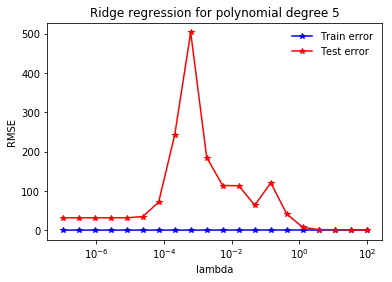

In [79]:
weights_naive = test_ridge_regression(x_naive, y_train, x_naive_val, y_validation, degrees = np.linspace(1,5,5), lambdas=np.logspace(-7,2,20))

## Ridge with no_nan


In [86]:
# normalize features
x_no_nan = x_train.copy()
x_no_nan = (x_no_nan - np.nanmean(x_no_nan, axis=0))/np.nanstd(x_no_nan, axis=0)
x_no_nan = np.nan_to_num(x_no_nan)
print('\nStd:', np.std(x_no_nan, axis=0))

# normalize features
x_no_nan_val = x_validation.copy()
x_no_nan_val = (x_no_nan_val - np.nanmean(x_no_nan_val, axis=0))/np.nanstd(x_no_nan_val, axis=0)
x_no_nan_val = np.nan_to_num(x_no_nan_val)
print('\nStd:', np.std(x_no_nan_val, axis=0))


Std: [ 0.9208  1.      1.      1.      0.5387  0.5387  0.5387  1.      1.      1.
  1.      1.      0.5387  1.      1.      1.      1.      1.      1.      1.
  1.      1.      1.      0.7745  0.7745  0.7745  0.5387  0.5387  0.5387
  1.    ]

Std: [ 0.9198  1.      1.      1.      0.5384  0.5384  0.5384  1.      1.      1.
  1.      1.      0.5384  1.      1.      1.      1.      1.      1.      1.
  1.      1.      1.      0.7763  0.7763  0.7763  0.5384  0.5384  0.5384
  1.    ]


degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=46660292.636
train acc :  0.81505
validation acc :  0.79902
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=46662156.869
train acc :  0.815055
validation acc :  0.81554
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=46676372.512
train acc :  0.81506
validation acc :  0.81596
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=46722702.239
train acc :  0.815075
validation acc :  0.8159
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=46668029.315
train acc :  0.815115
validation acc :  0.8157
degree=9, lambda=0.000, Training RMSE=0.745, Testing RMSE=45723747.321
train acc :  0.815015
validation acc :  0.81562
degree=9, lambda=0.000, Training RMSE=0.746, Testing RMSE=38859072.911
train acc :  0.81474
validation acc :  0.81566
degree=9, lambda=0.000, Training RMSE=0.751, Testing RMSE=14473873.327
train acc :  0.810255
validation acc :  0.81242
degree=9, lambda=0.001, Training RMSE=0.776, Testing 

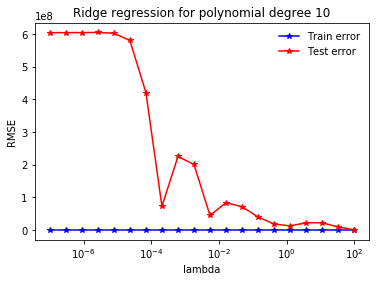

In [87]:
weights_no_nan, degree_no_nan, lambda_no_nan = test_ridge_regression(x_no_nan, y_train, x_no_nan_val, y_validation, degrees = np.linspace(9,11,3), lambdas=np.logspace(-7,2,20))

## Submission


In [88]:
y_test, x_test, ids_test, header = helper.load_csv_data(DATA_TEST)
x_test[x_test == -999] = np.nan

x_no_nan_test = x_test.copy()
x_no_nan_test = (x_no_nan_test - np.nanmean(x_no_nan_test, axis=0))/np.nanstd(x_no_nan_test, axis=0)
x_no_nan_test = np.nan_to_num(x_no_nan_test)
print('\nStd:', np.std(x_no_nan_test, axis=0))



Std: [ 0.9208  1.      1.      1.      0.5396  0.5396  0.5396  1.      1.      1.
  1.      1.      0.5396  1.      1.      1.      1.      1.      1.      1.
  1.      1.      1.      0.7744  0.7744  0.7744  0.5396  0.5396  0.5396
  1.    ]


In [91]:
degree_opt = degree_no_nan
weights_opt = weights_no_nan

_phi_test = lib.build_poly(x_no_nan_test, degree_opt)
y_pred = helper.predict_labels(weights_opt, _phi_test)




In [93]:
helper.create_csv_submission(ids_test, y_pred, 'ridge_no_nan1.csv')
print('Results saved ...')

Results saved ...
